# 对文章的方法的复刻

先跑一遍HRP, 记录权重和MST的顺序
然后, 根据k=\[5,10,30,50,100,150,200,250,300,all\],切割原来组合, 生成新的组合, 并重新标准化权重使得$\Sigma^N_n w_n = 1$
之后对这些组合进行评估.

代码运行时间比较长, 尤其是生成HRP权重的部分, 大约需要5小时. 实际环境中应该考虑用多进程加速. 

另外我写的io操作比较多, 每次生成一批数据后都保存到excel文件, 好处是比较容易检查, 坏处是耗时较长. 应该考虑用MySQL. 

# 生成基准HRP组合的权重

In [1]:
import framework_portfolio_weight_performace as portfolio_weight_performace
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os
import warnings

warnings.filterwarnings('ignore')

In [2]:
def draw_mst(matrix, k, ax, title, if_draw=False):
    '''
    功能: 绘制FC矩阵的最小生成树. 标记最核心的一个资产, 和最边缘的k个资产.

    matrix: 处理过的相关系数矩阵, 如FC和GMSC
    ax: 绘图位置, plt对象
    title: 绘图标题
    k: 选择的最远的资产的数量
    '''

    # 计算距离矩阵
    distance_matrix = np.sqrt(2 * (1 - matrix.values))
    
    # 创建图
    G = nx.Graph()
    
    # 添加带有权重的边和节点标签
    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix)):
            weight = np.round(distance_matrix[i][j], 4)
            G.add_edge(matrix.index[i], matrix.index[j], weight=weight)
    
    # 构建最小生成树
    mst = nx.minimum_spanning_tree(G)
    # 获取每个节点的度
    degrees = dict(mst.degree())
    # 找到度最高的节点（最紧密的节点）
    most_connected_node = max(degrees, key=degrees.get)
    # 按度排序节点，选择度最低的k个节点（最稀疏的节点）
    sparsest_nodes = sorted(degrees, key=degrees.get)[:k]
    all_nodes = sorted(degrees, key=degrees.get)

    if if_draw:
        # 使用Kamada-Kawai布局
        pos = nx.kamada_kawai_layout(mst)
        # 绘制所有节点
        nx.draw_networkx_nodes(mst, pos, node_color='lightgrey', node_size=400, ax=ax)
        # 突出显示中心节点
        nx.draw_networkx_nodes(mst, pos, nodelist=[most_connected_node], node_color='red', node_size=600, ax=ax)
        # 突出显示边缘节点
        nx.draw_networkx_nodes(mst, pos, nodelist=sparsest_nodes, node_color='green', node_size=600, ax=ax)
        # 绘制边
        nx.draw_networkx_edges(mst, pos, width=2, ax=ax, edge_color='black')
        # 节点标签
        nx.draw_networkx_labels(mst, pos, ax=ax)
        # 关闭坐标轴
        ax.set_title(title)
        ax.axis('off')  

    return sparsest_nodes, all_nodes

In [3]:
import gc


def weighted_degree_centrality(G):
    """
    计算加权度中心性（强度）。
    每个节点的加权度中心性是其所有邻接边的权重和, 每个权重加1。
    
    参数:
    G: 一个NetworkX图对象, 其边具有'weight'属性表示权重。

    返回:
    dict: 每个节点的加权度中心性（强度）。
    """
    centrality = {}
    for node in G.nodes():
        node_weight = sum((G[u][v]['weight'] + 1) for u, v in G.edges(node))
        centrality[node] = node_weight
    return centrality


def draw_mst_mixed(matrix, k, ax, title, if_draw=True):
    '''
    功能: 绘制FC矩阵的最小生成树. 标记最核心的一个资产, 和最边缘的k个资产.

    matrix: 处理过的相关系数矩阵, 如FC和GMSC
    ax: 绘图位置, plt对象
    title: 绘图标题
    k: 选择的最远的资产的数量
    '''

    # Calculate distance matrix
    distance_matrix = np.sqrt(2 * (1 - matrix.values))
    
    # Create the graph
    G = nx.Graph()

    # Add weighted edges
    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix)):
            weight = np.round(distance_matrix[i][j], 4)
            G.add_edge(matrix.index[i], matrix.index[j], weight=weight)

    # Build the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Calculate all pairs shortest path lengths for weighted and unweighted scenarios
    sp_weighted = {node: nx.single_source_dijkstra_path_length(mst, source=node, weight='weight') for node in mst.nodes()}
    sp_unweighted = {node: nx.single_source_dijkstra_path_length(mst, source=node) for node in mst.nodes()}

    # Calculate eccentricities using the shortest path lengths
    eccentricity_w = {node: nx.eccentricity(mst, v=node, sp=sp_weighted) for node in mst.nodes()}
    eccentricity_uw = {node: nx.eccentricity(mst, v=node, sp=sp_unweighted) for node in mst.nodes()}

    # Precompute centrality measures for all nodes
    degree_centrality = nx.degree_centrality(mst)
    degree_centrality_w = weighted_degree_centrality(mst)
    betweenness_centrality_w = nx.betweenness_centrality(mst, weight='weight')
    betweenness_centrality_uw = nx.betweenness_centrality(mst)
    closeness_centrality_w = nx.closeness_centrality(mst, distance='weight')
    closeness_centrality_uw = nx.closeness_centrality(mst)
    eigenvector_centrality_w = nx.eigenvector_centrality(mst, max_iter=5000, weight='weight')
    eigenvector_centrality_uw = nx.eigenvector_centrality(mst,max_iter=5000)

    N = mst.number_of_nodes()
    node_scores = {}
    for node in mst.nodes():
        # Retrieve precomputed centrality values
        R_D_w = degree_centrality[node]  # Degree centrality, treated as weighted
        R_D_uw = degree_centrality_w[node]  # Degree centrality, treated as unweighted
        R_BC_w = betweenness_centrality_w[node]  # Betweenness centrality, weighted
        R_BC_uw = betweenness_centrality_uw[node]  # Betweenness centrality, unweighted
        R_C_w = closeness_centrality_w[node]  # Closeness centrality, weighted
        R_C_uw = closeness_centrality_uw[node]  # Closeness centrality, unweighted
        R_E_w = eccentricity_w[node]  # Eccentricity, weighted
        R_E_uw = eccentricity_uw[node]  # Eccentricity, unweighted
        R_EC_w = eigenvector_centrality_w[node]  # Eigenvector centrality, weighted
        R_EC_uw = eigenvector_centrality_uw[node]  # Eigenvector centrality, unweighted

        # Explicit formulas for X and Y
        X = (R_D_w + R_D_uw + R_BC_w + R_BC_uw - 4) / 4 * (N - 1)
        Y = (R_E_w + R_E_uw + R_C_w + R_C_uw + R_EC_w + R_EC_uw - 6) / 6 * (N - 1)

        # Compute the final score for each node
        node_scores[node] = X + Y

    # Identify the most central and peripheral nodes
    sorted_nodes = sorted(node_scores, key=node_scores.get)
    most_central_node = sorted_nodes[0]
    most_peripheral_nodes = sorted_nodes[-k:]

    if if_draw:

        # 使用Kamada-Kawai布局
        pos = nx.kamada_kawai_layout(mst)
        
        # 绘制所有节点
        nx.draw_networkx_nodes(mst, pos, node_color='lightgrey', node_size=400, ax=ax)
        
        # 突出显示中心节点
        nx.draw_networkx_nodes(mst, pos, nodelist=[most_central_node], node_color='red', node_size=600, ax=ax)
        
        # 突出显示边缘节点
        nx.draw_networkx_nodes(mst, pos, nodelist=most_peripheral_nodes, node_color='green', node_size=600, ax=ax)
        
        # 绘制边
        nx.draw_networkx_edges(mst, pos, width=2, ax=ax, edge_color='black')
        
        # 节点标签
        nx.draw_networkx_labels(mst, pos, ax=ax)

        ax.set_title(title)
        ax.axis('off')  # 关闭坐标轴
    
    # 垃圾清理
    del G, mst, sp_weighted, sp_unweighted, eccentricity_w, eccentricity_uw
    del degree_centrality, degree_centrality_w, betweenness_centrality_w, betweenness_centrality_uw
    del closeness_centrality_w, closeness_centrality_uw, eigenvector_centrality_w, eigenvector_centrality_uw
    del node_scores
    gc.collect()  

    return most_central_node, sorted_nodes

In [4]:
price_data = portfolio_weight_performace.readWindSP500()
eturn_data = price_data.pct_change().dropna()
SP500_df = pd.read_excel(r'..\WashedData\SP500indexFromWind.xlsx', index_col=0, header=0)
cumulative_return_SP500 = (1 + SP500_df.pct_change().dropna()).cumprod()

In [5]:
"""回测"""
w = 120
window_size = int(w)    # 窗口大小

# 初始化一些列表来保存所有的实验结果
# lis_weights_HRP = []
lis_weights_HRP_FC = []
lis_weights_HRP_GMSC = []

lis_test_date = []
lis_FC_ranked = []
lis_GMSC_ranked = []


count = 0
# 迭代DataFrame，创建每个实验期的切片
for start_day in tqdm(range(len(price_data) - window_size - 1)):

    end_train_day = start_day + window_size

    # 实验期的切片
    experiment_slice = price_data.iloc[start_day:end_train_day]

    # 测试期的切片, 从实验期开始后120
    test_date = end_train_day + 1
    lis_test_date.append(price_data.index[test_date])
    returns_train = experiment_slice.pct_change().dropna()

    '''# HRP
    HRP_instance = portfolio_weight_performace.GenPortfolioWeight(returns_train, shrinkage=False)
    weights_HRP = HRP_instance.genHRPweights()
    lis_weights_HRP.append(weights_HRP)'''

    # 记录MST顺序
    instance0 = portfolio_weight_performace.CorrProcess(returns_train)
    FC_matrix , GMSC_matrix = instance0.FC_GMSC()

    sparsest_nodes_FC, all_nodes_FC = draw_mst(FC_matrix, k=100, ax=1, title='MST of FC Matrix', if_draw=False)
    sparsest_nodes_GMSC, all_nodes_GMSC = draw_mst(GMSC_matrix, k=100, ax=1, title='MST of GMSC Matrix', if_draw=False)

    lis_FC_ranked.append(all_nodes_FC)
    lis_GMSC_ranked.append(all_nodes_GMSC)

    # HRP FC
    HRP_FC = portfolio_weight_performace.GenPortfolioWeight(returns_train, special_corr=FC_matrix, shrinkage=False)
    weights_FC = HRP_FC.genHRPweights()
    lis_weights_HRP_FC.append(weights_FC)

    # HRP GMSC
    HRP_GMSC = portfolio_weight_performace.GenPortfolioWeight(returns_train, special_corr=GMSC_matrix, shrinkage=False)
    weights_GMSC = HRP_GMSC.genHRPweightsSpecialCorr()
    lis_weights_HRP_GMSC.append(weights_GMSC)


lis_weights_ND = []
for series in lis_weights_HRP_FC:
    count = len(series)
    equal_weight = 1 / count
    # 创建一个新的Series，索引与原Series相同，每个元素的值都是等权重
    equal_weight_series = pd.Series(equal_weight, index=series.index)
    lis_weights_ND.append(equal_weight_series)

100%|██████████| 5695/5695 [7:20:44<00:00,  4.64s/it]  


In [6]:
df_weight_HRP_FC = pd.DataFrame(lis_weights_HRP_FC, index=lis_test_date)
df_weight_HRP_GMSC = pd.DataFrame(lis_weights_HRP_GMSC, index=lis_test_date)
df_weight_ND = pd.DataFrame(lis_weights_ND, index=lis_test_date)  
df_FC_ranked = pd.DataFrame(lis_FC_ranked, index=lis_test_date)
df_GMSC_ranked = pd.DataFrame(lis_GMSC_ranked, index=lis_test_date)


In [7]:
with pd.ExcelWriter(r'original_alpha/all_nodes_weights.xlsx') as writer:
    print('保存权重、收益率和累计收益率到一个Excel文件, Excel文件已经打开')
    # pd.DataFrame(price_data.columns).to_excel(writer, sheet_name='selected_assets')
    df_weight_HRP_FC.to_excel(writer, sheet_name='df_weight_HRP_FC')
    df_weight_HRP_GMSC.to_excel(writer, sheet_name='df_weight_HRP_GMSC')
    df_weight_ND.to_excel(writer, sheet_name='df_weight_ND')
    df_FC_ranked.to_excel(writer, sheet_name='df_FC_ranked')
    df_GMSC_ranked.to_excel(writer, sheet_name='df_GMSC_ranked')

保存权重、收益率和累计收益率到一个Excel文件, Excel文件已经打开


In [8]:
portfolio_HRP_FC = portfolio_weight_performace.PortfolioPerformance(lis_weights = df_weight_HRP_FC,
                                                        price_df=price_data,
                                                        lis_test_date=lis_test_date,
                                                        title='HRP_FC')
portfolio_HRP_GMSC = portfolio_weight_performace.PortfolioPerformance(lis_weights = df_weight_HRP_GMSC,
                                                        price_df=price_data,
                                                        lis_test_date=lis_test_date,
                                                        title='HRP_GMSC')

In [9]:
weight_df_HRP, daily_return_HRP, cumulative_return_HRP = portfolio_HRP_FC.plot_charts()

In [10]:
weight_df_HRP, daily_return_HRP, cumulative_return_HRP = portfolio_HRP_GMSC.plot_charts()

In [11]:
df_FC_ranked = pd.DataFrame(lis_FC_ranked,index=lis_test_date)
df_GMSC_ranked = pd.DataFrame(lis_GMSC_ranked,index=lis_test_date)
df_GMSC_ranked

0       1       2      3      4      5       6      7    \
2000-07-12  AAPL.O  ACGL.O   ADI.O  ADM.N  ADP.O  AEE.N   AES.N  AFL.N   
2000-07-13  AAPL.O   ADI.O   ADM.N  ADP.O  AEE.N  AES.N   AFL.N  AIG.N   
2000-07-14  AAPL.O   ADI.O   ADM.N  ADP.O  AEE.N  AES.N   AFL.N  AIG.N   
2000-07-17  AAPL.O   ADI.O   ADM.N  ADP.O  AEE.N  AES.N   AFL.N  AIG.N   
2000-07-18  AAPL.O   ADI.O   ADM.N  ADP.O  AEE.N  AES.N   AFL.N  AIG.N   
...            ...     ...     ...    ...    ...    ...     ...    ...   
2023-12-25  AAPL.O   ADM.N  ADSK.O  AEP.O  AES.N  AFL.N  AKAM.O  ALB.N   
2023-12-26  AAPL.O   ADM.N  ADSK.O  AEP.O  AES.N  AFL.N  AKAM.O  ALB.N   
2023-12-27  AAPL.O   ADM.N  ADSK.O  AEP.O  AES.N  AFL.N  AKAM.O  ALB.N   
2023-12-28  AAPL.O   ADM.N  ADSK.O  AEP.O  AES.N  AFL.N  AKAM.O  ALB.N   
2023-12-29  AAPL.O   ADM.N  ADSK.O  AEP.O  AES.N  AFL.N  AKAM.O  ALB.N   

               8      9    ...     342     343     344     345     346  \
2000-07-12   AIG.N  ALB.N  ...   AEP.O    HD.N  INTC.O    PG.N   APA.O   
2000-07-13   ALB.N  AMD.O  ...   PEG.N    PG.N   SPG.N   TER.O   APA.O   
2000-07-14   ALB.N  AMD.O  ...   APA.O   BAC.N    HD.N    PG.N  INTC.O   
2000-07-17   AJG.N  ALB.N  ...  BKNG.O    HD.N    PG.N   AEP.O   FDS.N   
2000-07-18   ALB.N  AMD.O  ...    HD.N    PG.N  SCHW.N   AEP.O   SPG.N   
...            ...    ...  ...     ...     ...     ...     ...     ...   
2023-12-25   AMT.N  AON.N  ...   PEP.O  SNPS.O   WEC.N  ADBE.O   AMD.O   
2023-12-26  ANSS.O  AON.N  ...  ORLY.O  SNPS.O   SYK.N  ADBE.O   AMD.O   
2023-12-27  ANSS.O  AON.N  ...    MO.N   NOC.N  ORLY.O  ADBE.O   AMD.O   
2023-12-28  ANSS.O  AON.N  ...    MO.N   NOC.N  ORLY.O  ADBE.O   AMD.O   
2023-12-29   AME.N  AMT.N  ...   NOC.N  ORLY.O   PEP.O  ADBE.O   AEE.N   

               347     348    349     350     351  
2000-07-12   SPG.N   FDS.N   LH.N  VRSN.O  ADBE.O  
2000-07-13   CMS.N   FDS.N   LH.N  VRSN.O  ADBE.O  
2000-07-14   SPG.N   FDS.N   LH.N  VRSN.O  ADBE.O  
2000-07-17  INTC.O   SPG.N   LH.N  VRSN.O  ADBE.O  
2000-07-18   FDS.N  INTC.O   LH.N  VRSN.O  ADBE.O  
...            ...     ...    ...     ...     ...  
2023-12-25    CB.N    KO.N  MKC.N   KEY.N   AJG.N  
2023-12-26    CB.N   MKC.N  PEP.O   KEY.N   AJG.N  
2023-12-27    CB.N   MKC.N  PEP.O   KEY.N   AJG.N  
2023-12-28    CB.N   MKC.N  PEP.O   KEY.N   AJG.N  
2023-12-29   AMD.O    CB.N  KEY.N   MKC.N   AJG.N  

[5695 rows x 352 columns]

In [12]:
with pd.ExcelWriter(r'original_alpha/original_weights_HRP_FC.xlsx') as writer:
    weight_df_HRP.to_excel(writer, sheet_name='weight_HRP_FC')
    daily_return_HRP.to_excel(writer, sheet_name='daily_return_HRP_FC')
    cumulative_return_HRP.to_excel(writer, sheet_name='cumulative_return_HRP_FC')
    df_FC_ranked.to_excel(writer, sheet_name='FC_ranked')

In [13]:
with pd.ExcelWriter(r'original_alpha/original_weights_HRP_GMSC.xlsx') as writer:
    weight_df_HRP.to_excel(writer, sheet_name='weight_HRP_GMSC')
    daily_return_HRP.to_excel(writer, sheet_name='daily_return_HRP_GMSC')
    cumulative_return_HRP.to_excel(writer, sheet_name='cumulative_return_HRP_GMSC')
    df_GMSC_ranked.to_excel(writer, sheet_name='GMSC_ranked')

# 根据基准HRP组合创建FC和GMSC的不同k组合

In [37]:
import pandas as pd

# 读取Excel文件
file_path_FC = 'original_alpha/original_weights_HRP_FC.xlsx'
sheets_dict_FC = pd.read_excel(file_path_FC, sheet_name=None, index_col=0)
file_path_GMSC = 'original_alpha/original_weights_HRP_GMSC.xlsx'
sheets_dict_GMSC = pd.read_excel(file_path_GMSC, sheet_name=None, index_col=0)

# 处理各个sheet: FC
weight_df_HRP_FC = sheets_dict_FC['weight_HRP_FC']
daily_return_HRP_FC = pd.read_excel(file_path_FC, sheet_name='daily_return_HRP_FC', index_col=0, header=0)
df_FC_ranked = pd.read_excel(file_path_FC, sheet_name='FC_ranked', index_col=0, header=0)

# 处理各个sheet: GMSC
weight_df_HRP_GMSC = sheets_dict_GMSC['weight_HRP_GMSC']
daily_return_HRP_GMSC = pd.read_excel(file_path_GMSC, sheet_name='daily_return_HRP_GMSC', index_col=0, header=0)
df_GMSC_ranked = pd.read_excel(file_path_GMSC, sheet_name='GMSC_ranked', index_col=0, header=0)

In [38]:
def select_and_normalize_weights(k, weight_df_HRP, df_ranked, output_path, FC_GMSC='FC'):
    # 初始化存储选择后权重的DataFrame
    selected_weight = pd.DataFrame(0, index=weight_df_HRP.index, columns=weight_df_HRP.columns)
    
    # 对于每天的数据
    for date in weight_df_HRP.index:
        # 获取当天边缘程度排名最低的k个证券
        securities = df_ranked.loc[date].iloc[:k].values
        
        # 在HRP权重中检索这些证券的权重，并赋值到新的DataFrame
        selected_weight.loc[date, securities] = weight_df_HRP.loc[date, securities]
        
        # 归一化权重，使得每行的权重总和为1
        total_weight = selected_weight.loc[date].sum()
        if total_weight > 0:
            selected_weight.loc[date] /= total_weight

    # 保存DataFrame为CSV
    selected_weight.to_csv(f'{output_path}/k_{k}_selected_weight_{FC_GMSC}.csv')


In [39]:
output_path = 'original_alpha'

for k in tqdm([5,10,20,30,50,100,150,200,250,300,350]):
    select_and_normalize_weights(k, weight_df_HRP_FC, df_FC_ranked, output_path, FC_GMSC='FC')
    select_and_normalize_weights(k, weight_df_HRP_GMSC, df_GMSC_ranked, output_path, FC_GMSC='GMSC')

100%|██████████| 11/11 [04:06<00:00, 22.37s/it]


# 读取不同k组合的权重, 评估表现

读取权重数据

In [17]:
import pandas as pd
import numpy as numpy
from tqdm import tqdm
# %load_ext autoreload
# %aimport framework_portfolio_weight_performace

import framework_portfolio_weight_performace as portfolio_weight_performace

def read_weights(k, path='original_alpha'):
    weights_GMSC = pd.read_csv(f'{path}/k_{k}_selected_weight_GMSC.csv', index_col=0)
    weights_FC = pd.read_csv(f'{path}/k_{k}_selected_weight_FC.csv', index_col=0)
    
    return {
        f'k_{k}_GMSC_df': weights_GMSC,
        f'k_{k}_FC_df': weights_FC
    }

In [18]:
k_values = [5, 10, 20, 30, 50, 100, 200, 300, 350]
weights_dict = {}
for k in k_values:
    weights = read_weights(k)
    weights_dict.update(weights)

In [19]:
price_data_global = portfolio_weight_performace.readWindSP500()

生成PortfolioPerformance对象

In [20]:
# %matplotlib inline
performance_objects = {}

for k in tqdm(k_values):
    gmsc_key = f'k_{k}_GMSC_df'
    fc_key = f'k_{k}_FC_df'

    # 创建性能对象并存储
    performance_objects[f'portfolio_{fc_key}'] = portfolio_weight_performace.PortfolioPerformance(
        lis_weights=weights_dict[fc_key],
        price_df=price_data_global,
        lis_test_date=weights_dict[fc_key].index.tolist(),
        title=f'HRP_FC_{k}'
    )

    performance_objects[f'portfolio_{gmsc_key}'] = portfolio_weight_performace.PortfolioPerformance(
        lis_weights=weights_dict[gmsc_key],
        price_df=price_data_global,
        lis_test_date=weights_dict[gmsc_key].index.tolist(),
        title=f'HRP_GMSC_{k}'
    )


100%|██████████| 9/9 [02:06<00:00, 14.05s/it]


各个组合有无手续费

In [21]:
from matplotlib import pyplot as plt

for key, obj in tqdm(performance_objects.items()):
    plt.figure(figsize=(20, 10))
    plt.plot(obj.feefree_cumulative_return, label='Fee-free Cumulative Return')
    plt.plot(obj.daily_portfolio_price-1, label='Cumulative Return')
    plt.title(key)
    plt.legend()
    plt.show()


100%|██████████| 18/18 [00:00<00:00, 93.26it/s]


所有组合有无手续费

In [22]:
SP500_df = pd.read_excel(r'..\WashedData\SP500indexFromWind.xlsx', index_col=0, header=0)
SP500_return = SP500_df.pct_change().dropna()
SP500_cumulative_return = (1 + SP500_return).cumprod()

100%|██████████| 18/18 [00:00<00:00, 390.74it/s]


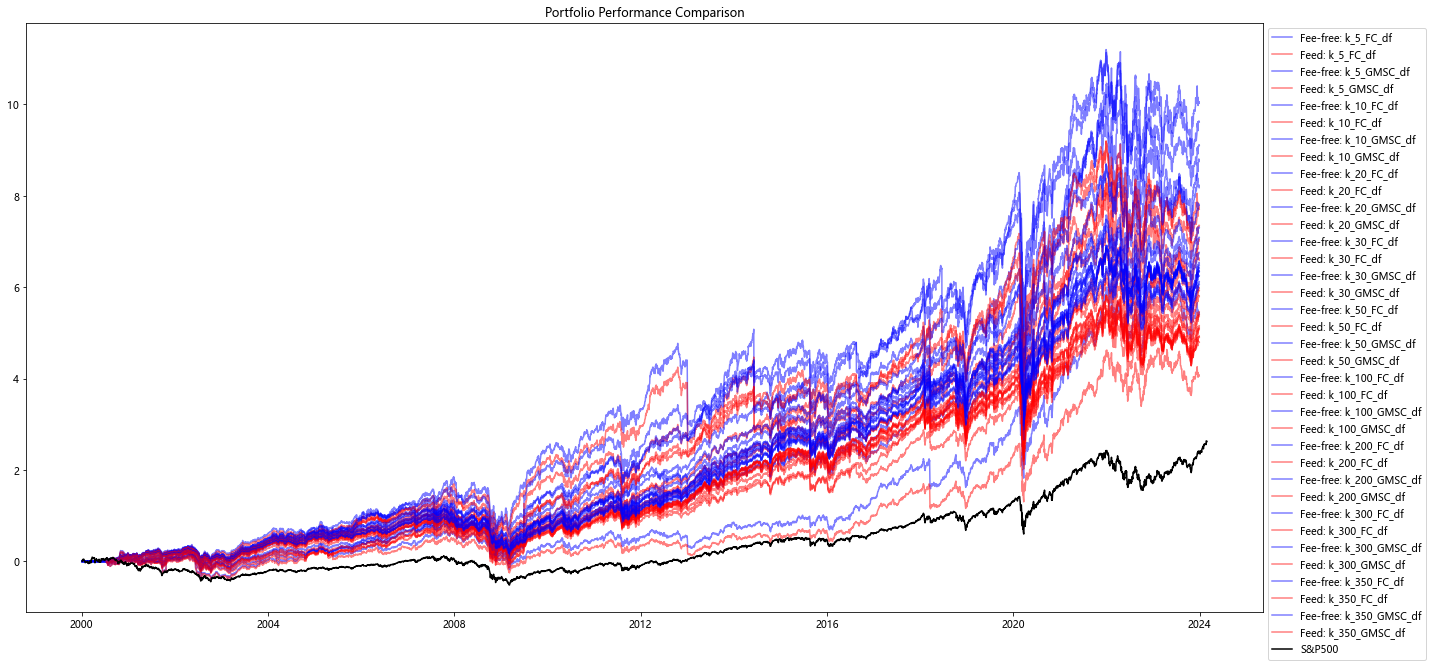

In [41]:
%matplotlib inline
# 创建一个大图用来绘制所有的数据
plt.figure(figsize=(20, 10))  # 可以调整图的大小

for key, obj in tqdm(performance_objects.items()):
    # 绘制无费用累计收益，使用蓝色系
    plt.plot(obj.feefree_cumulative_return, label=f'Fee-free: {key[10:]}', color='blue', alpha=0.5)
    # 绘制每日投资组合价格变化，使用红色系
    plt.plot(obj.daily_portfolio_price - 1, label=f'Feed: {key[10:]}', color='red', alpha=0.5)

plt.plot(SP500_cumulative_return - 1, label='S&P500', color='black')
# 添加标题
plt.title('Portfolio Performance Comparison')
# 显示图例，可能需要调整位置或使用滚动条来显示所有图例
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# 调整布局以防止标签被裁剪
plt.tight_layout()
# 显示图形
plt.show()

In [24]:
# 创建一个图和两个子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 18))  # 两个子图，垂直排列

for key, obj in tqdm(performance_objects.items()):
    # 在第一个子图上绘制无手续费的累计收益，使用蓝色系
    ax1.plot(obj.feefree_cumulative_return, label=f'Fee-free Cumulative Return: {key}')
    # 在第二个子图上绘制有手续费的每日投资组合价格变化，使用红色系
    ax2.plot(obj.daily_portfolio_price - 1, label=f'Daily Portfolio Price Change: {key}')

# 设置第一个子图的标题和图例
ax1.set_title('Fee-free Cumulative Returns')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 设置第二个子图的标题和图例
ax2.set_title('Cumulative Return with Fees')
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax1.plot(SP500_cumulative_return - 1, label='S&P500', color='black')
ax2.plot(SP500_cumulative_return - 1, label='S&P500', color='black')

# 自动调整子图参数，确保标签不会重叠或被裁剪
fig.tight_layout()
# 显示图形
plt.show()

100%|██████████| 18/18 [00:00<00:00, 818.19it/s]


权重分布

  0%|          | 0/18 [00:00<?, ?it/s]

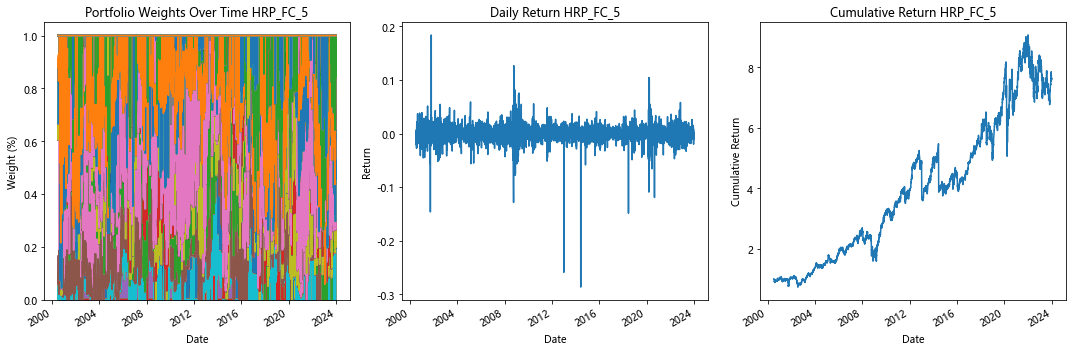

  6%|▌         | 1/18 [00:08<02:22,  8.40s/it]

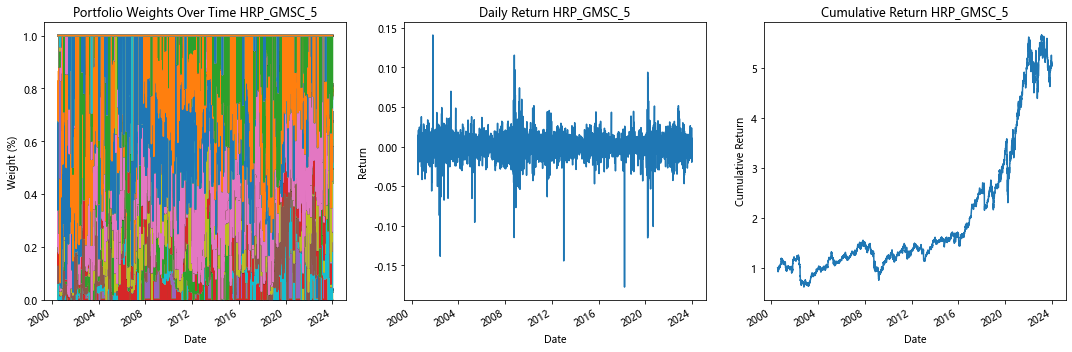

 11%|█         | 2/18 [00:18<02:29,  9.37s/it]

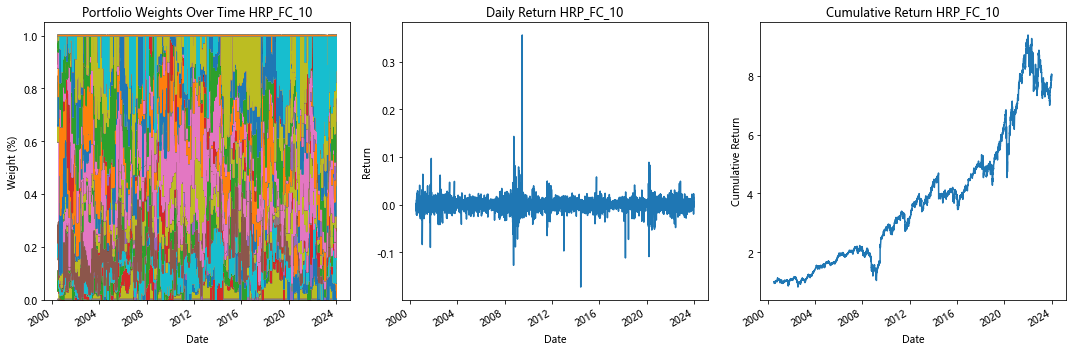

 17%|█▋        | 3/18 [00:27<02:19,  9.28s/it]

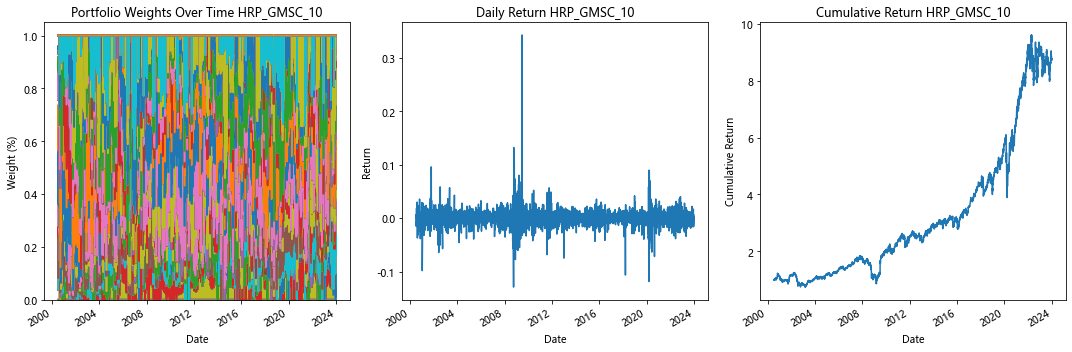

 22%|██▏       | 4/18 [00:38<02:20, 10.00s/it]

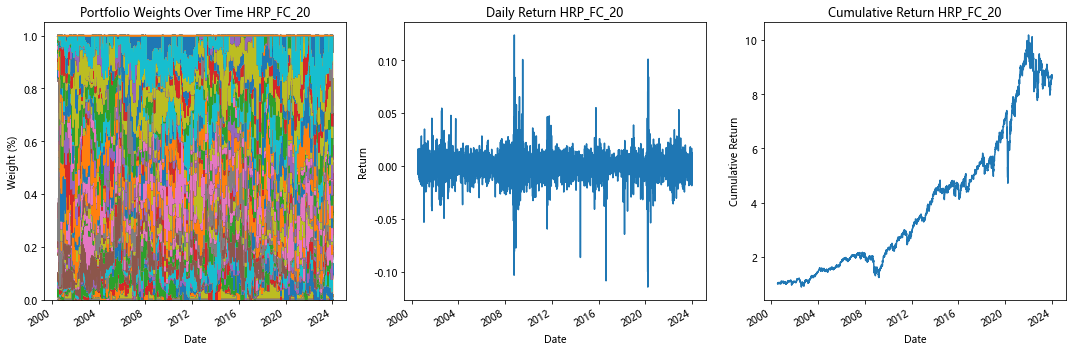

 28%|██▊       | 5/18 [00:46<02:00,  9.25s/it]

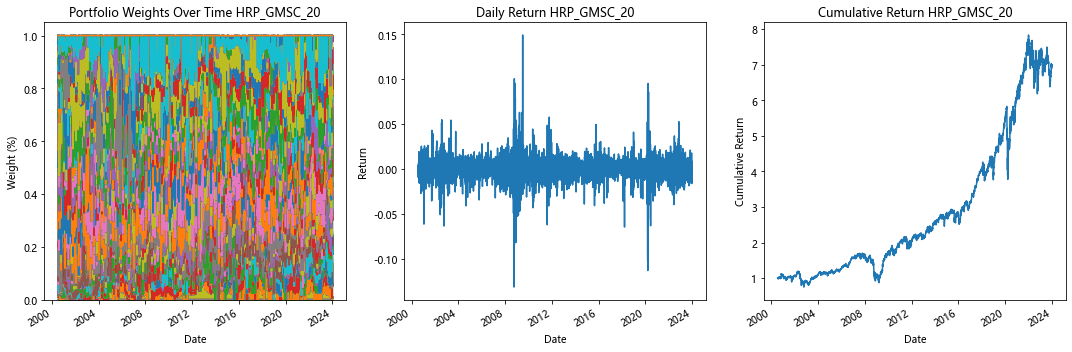

 33%|███▎      | 6/18 [00:55<01:48,  9.07s/it]

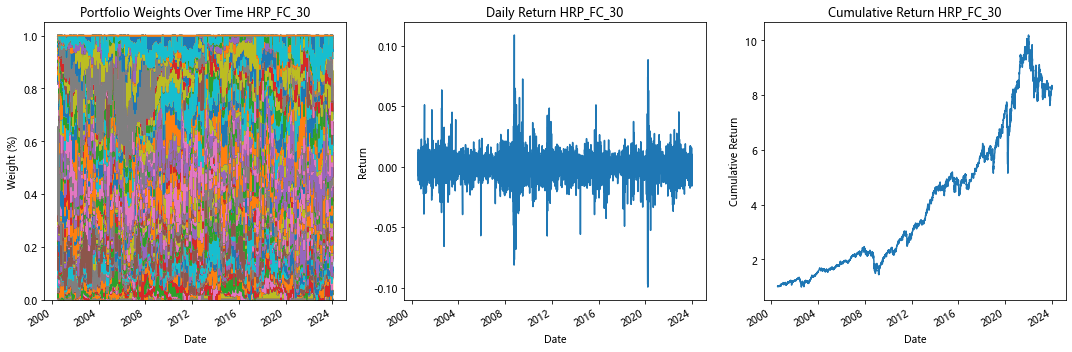

 39%|███▉      | 7/18 [01:02<01:33,  8.49s/it]

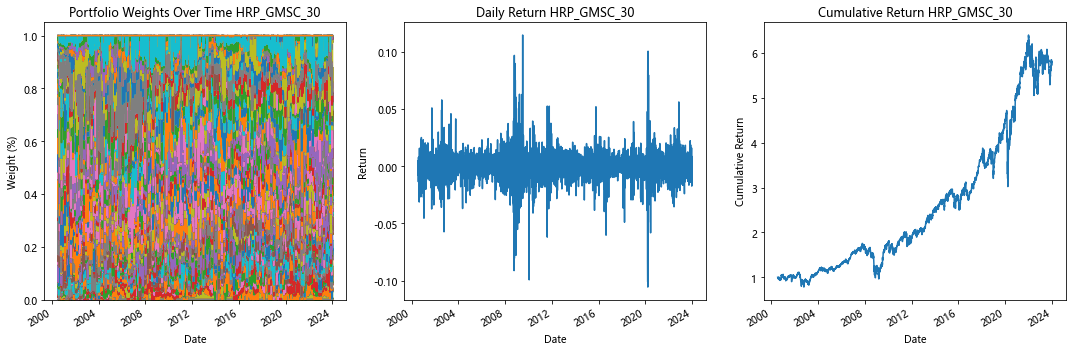

 44%|████▍     | 8/18 [01:10<01:23,  8.31s/it]

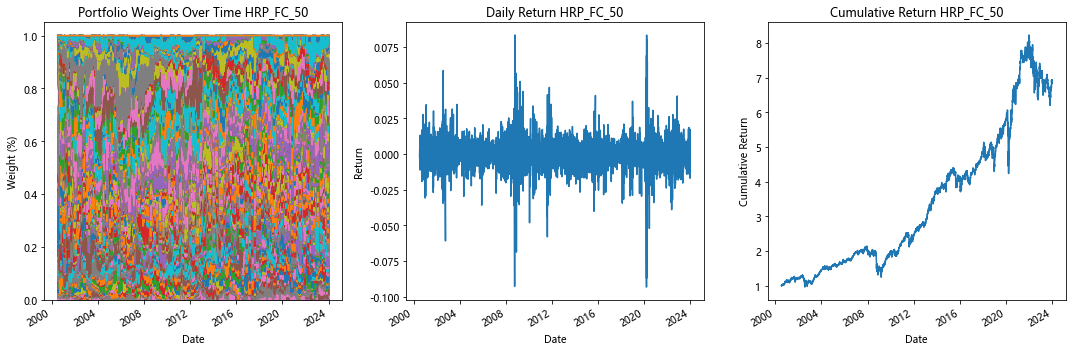

 50%|█████     | 9/18 [01:16<01:09,  7.71s/it]

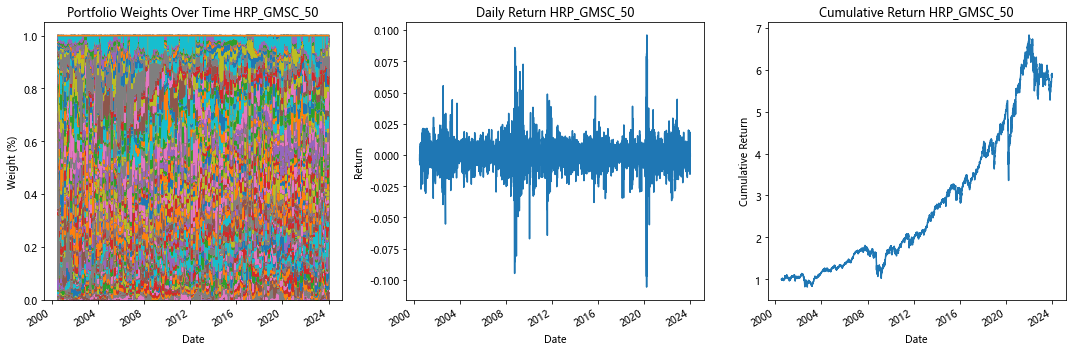

 56%|█████▌    | 10/18 [01:24<00:59,  7.49s/it]

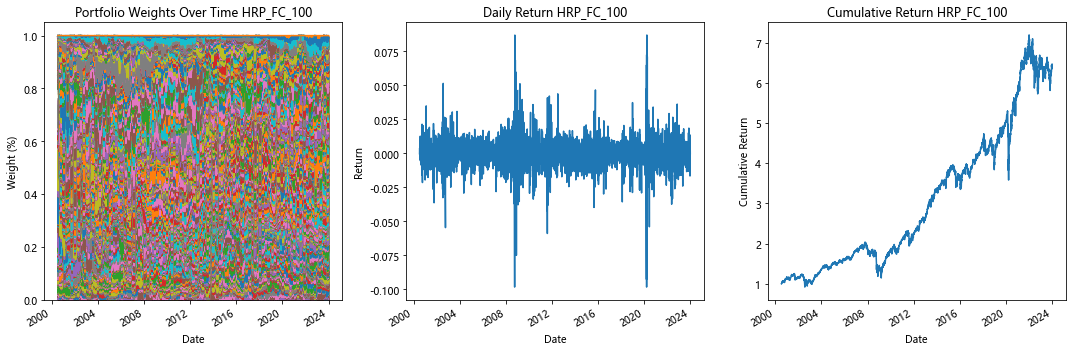

 61%|██████    | 11/18 [01:29<00:48,  6.95s/it]

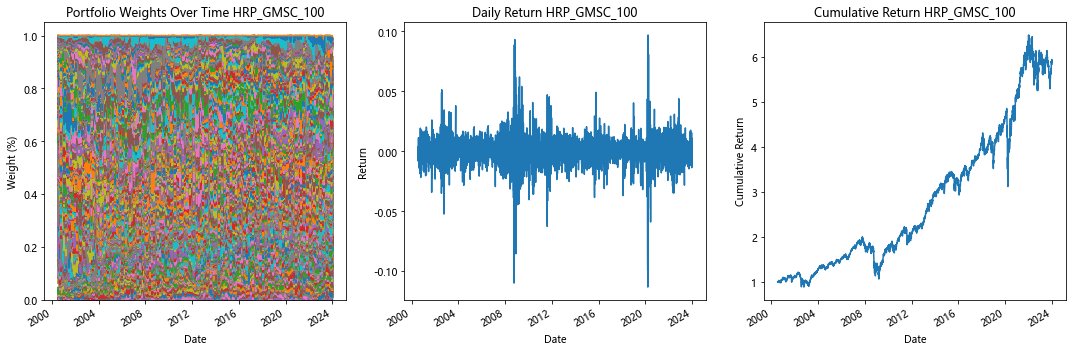

 67%|██████▋   | 12/18 [01:35<00:40,  6.74s/it]

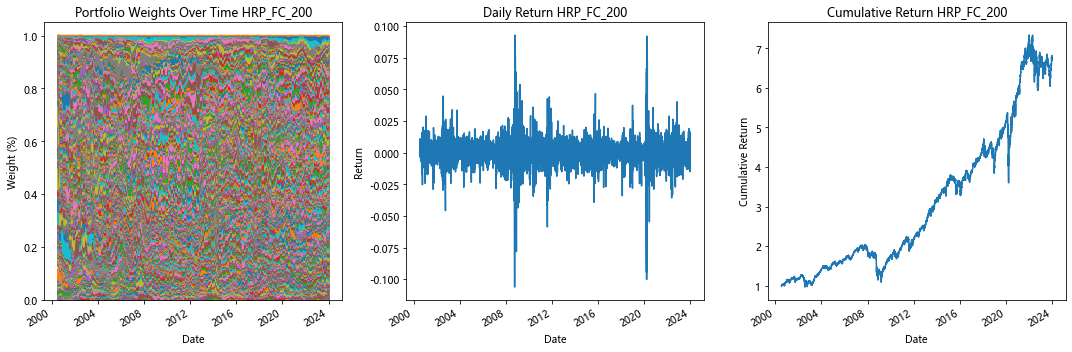

 72%|███████▏  | 13/18 [01:41<00:31,  6.27s/it]

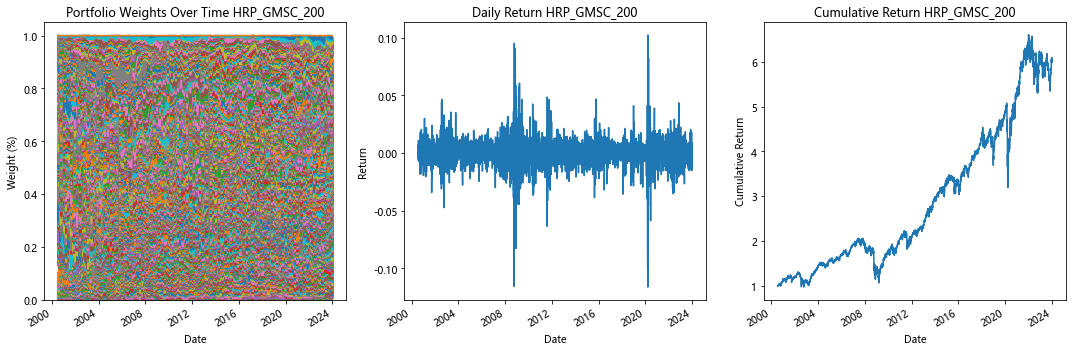

 78%|███████▊  | 14/18 [01:46<00:24,  6.01s/it]

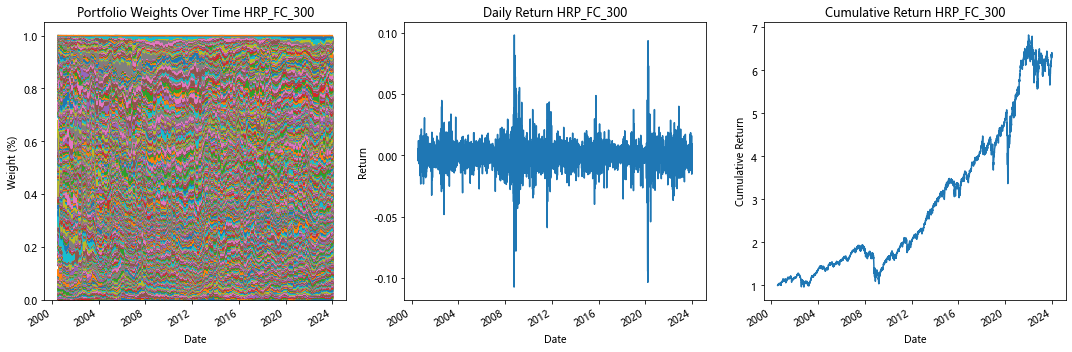

 83%|████████▎ | 15/18 [01:51<00:16,  5.66s/it]

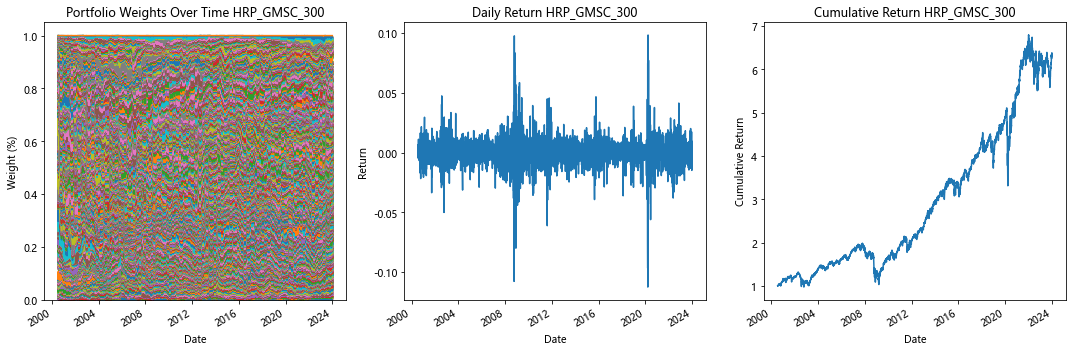

 89%|████████▉ | 16/18 [01:56<00:10,  5.44s/it]

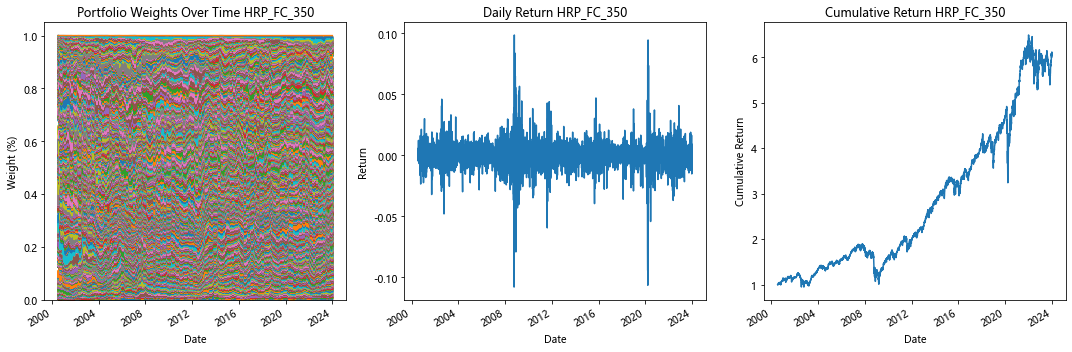

 94%|█████████▍| 17/18 [02:02<00:05,  5.57s/it]

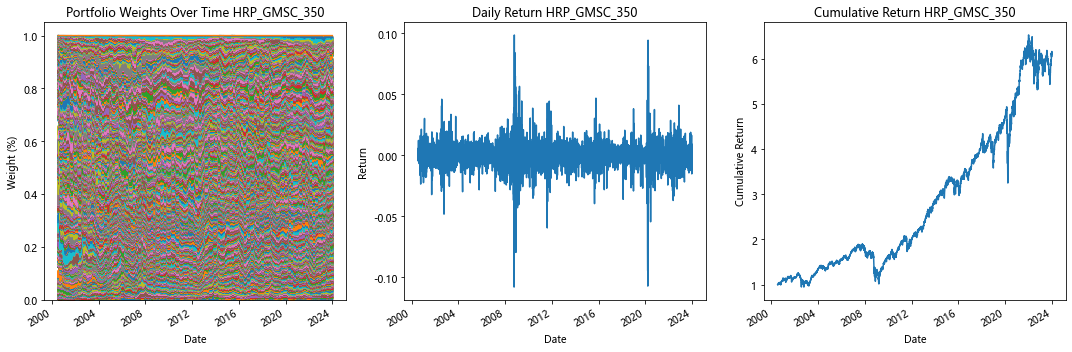

100%|██████████| 18/18 [02:07<00:00,  7.06s/it]


In [25]:
%matplotlib inline

for key, obj in tqdm(performance_objects.items()):
    obj.plot_charts(if_show_pic=True)

调用PortfolioPerformance对象获得数据, 保存数据

In [26]:
import os
from tqdm import tqdm
folder = 'original_alpha/performance'
if not os.path.exists(folder):
    os.makedirs(folder)

In [27]:
for key, obj in tqdm(performance_objects.items()):
    
    weight_df, daily_return, cumulative_return = obj.plot_charts(if_show_pic=False)
    turnover_rates= obj.turnover_rates
    feefree_cumulative_return= obj.feefree_cumulative_return

    with pd.ExcelWriter(f'original_alpha/performance/weights_returns_{key}.xlsx') as writer:
        weight_df.to_excel(writer, sheet_name='weight')
        daily_return.to_excel(writer, sheet_name='daily_return')
        cumulative_return.to_excel(writer, sheet_name='cumulative_return')
        turnover_rates.to_excel(writer, sheet_name='turnover_rates')
        feefree_cumulative_return.to_excel(writer, sheet_name='feefree_cumulative_return')



100%|██████████| 18/18 [09:16<00:00, 30.89s/it]


读取表现数据, 进行评估

In [28]:
import os

# 设定文件夹路径
folder_path = 'original_alpha/performance'

# 列出符合条件的文件
files = [f for f in os.listdir(folder_path) if f.startswith('weights_returns') and f.endswith('.xlsx')]

data_list = []
for filename in tqdm(files):
    # 解析文件名以获取参数
    parts = filename.replace('weights_returns_portfolio_', '').replace('.xlsx', '').split('_')
    k = parts[1]
    strategy_type = parts[2]
    
    # 构建完整的文件路径
    file_path = os.path.join(folder_path, filename)

    # 读取 Excel 文件中的数据
    daily_return = pd.read_excel(file_path, sheet_name='daily_return')
    daily_return.columns = ['date', 'daily_return']
    daily_return.set_index('date', inplace=True)

    # 将解析的参数和数据存储
    data_list.append({
        'k': k,
        'strategy_type': strategy_type,
        'daily_return': daily_return,
    })

100%|██████████| 18/18 [01:55<00:00,  6.39s/it]


In [29]:
df = pd.DataFrame(data_list)

In [30]:
df.iloc[0]

k                                                              100
strategy_type                                                   FC
daily_return                 daily_return
date                 ...
Name: 0, dtype: object

In [31]:
import pandas as pd
import numpy as np

def calculate_financial_metrics(df, risk_free_rate=0.03):
    """
    Calculate annualized return, annualized standard deviation, Sharpe ratio, and maximum drawdown.

    Args:
    df (DataFrame): DataFrame with a 'daily_return' column and datetime index.
    risk_free_rate (float): Annual risk-free rate, default is 3%.

    Returns:
    tuple: (annualized return, annualized standard deviation, Sharpe ratio, maximum drawdown)
    """
    # 确保'daily_return'列存在
    if 'daily_return' not in df.columns:
        raise ValueError("DataFrame must include a 'daily_return' column")

    # 年化收益率
    daily_return = df['daily_return']
    annualized_return = np.prod(1 + daily_return) ** (252 / len(daily_return)) - 1

    # 年化标准差
    annualized_std = daily_return.std() * np.sqrt(252)

    # 夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std

    # 最大回撤
    cumulative_returns = (1 + daily_return).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    return annualized_return, annualized_std, sharpe_ratio, max_drawdown

In [32]:
# 定义时期
periods = {
    'p-1': ('2001-01-01', '2006-12-31'),
    'p-2': ('2007-01-01', '2009-12-31'),
    'p-3': ('2010-01-01', '2019-12-31'),
    'p-4': ('2020-01-01', '2020-04-30'),
    'p-5': ('2020-05-01', '2021-08-31')
}

df = pd.DataFrame(data_list)

# 遍历每个时期
for period_name, (start_date, end_date) in periods.items():

    col_names = [f"{period_name} {metric}" for metric in ["an~return", "an~std", "sharpe", "max~draw"]]
    
    for idx, row in df.iterrows():
        # 提取特定时期数据
        period_data = row['daily_return'].loc[start_date:end_date]
        # 计算金融指标
        if not period_data.empty:
            results = calculate_financial_metrics(period_data)
            # 将结果添加到DataFrame中
            df.loc[idx, col_names[0]] = results[0]  # an~return
            df.loc[idx, col_names[1]] = results[1]  # an~std
            df.loc[idx, col_names[2]] = results[2]  # sharpe
            df.loc[idx, col_names[3]] = results[3]  # max~draw
        else:
            # 填充NaN
            df.loc[idx, col_names] = [np.nan] * 4

In [33]:
df.to_csv('original_method_all_result.csv')

In [34]:
df_temp = df.drop(['daily_return'],axis=1)
df_temp

k strategy_type  p-1 an~return  p-1 an~std  p-1 sharpe  p-1 max~draw  \
0   100            FC       0.081078    0.127839    0.399553     -0.267651   
1   100          GMSC       0.085597    0.134614    0.413010     -0.269157   
2    10            FC       0.112058    0.176112    0.465941     -0.300653   
3    10          GMSC       0.044593    0.182438    0.079989     -0.408090   
4   200            FC       0.091008    0.122099    0.499662     -0.244183   
5   200          GMSC       0.093010    0.131577    0.478887     -0.255361   
6    20            FC       0.113646    0.157794    0.530096     -0.275379   
7    20          GMSC       0.061964    0.163135    0.195938     -0.371630   
8   300            FC       0.082599    0.123159    0.427078     -0.250326   
9   300          GMSC       0.082946    0.127167    0.416349     -0.259247   
10   30            FC       0.114954    0.145744    0.582896     -0.267219   
11   30          GMSC       0.067594    0.148286    0.253527     -0.296638   
12  350            FC       0.079214    0.124056    0.396712     -0.249750   
13  350          GMSC       0.079648    0.124313    0.399381     -0.249695   
14   50            FC       0.093470    0.133482    0.475498     -0.262437   
15   50          GMSC       0.072564    0.141741    0.300296     -0.284405   
16    5            FC       0.130475    0.215325    0.466619     -0.329015   
17    5          GMSC       0.021232    0.220595   -0.039749     -0.510998   

    p-2 an~return  p-2 an~std  p-2 sharpe  p-2 max~draw  ...  p-3 sharpe  \
0        0.003666    0.229624   -0.114685     -0.435659  ...    0.626458   
1        0.005657    0.264428   -0.092061     -0.468133  ...    0.542614   
2        0.124022    0.367959    0.255523     -0.532103  ...    0.347277   
3        0.121471    0.363764    0.251456     -0.533916  ...    0.519941   
4       -0.027349    0.242706   -0.236289     -0.465878  ...    0.697480   
5       -0.025892    0.265356   -0.210632     -0.481847  ...    0.600165   
6        0.044298    0.276638    0.051684     -0.431361  ...    0.623097   
7        0.039088    0.298972    0.030397     -0.486446  ...    0.641021   
8       -0.030064    0.248246   -0.241955     -0.466887  ...    0.696054   
9       -0.031598    0.255371   -0.241209     -0.480715  ...    0.673501   
10       0.026139    0.247113   -0.015623     -0.416675  ...    0.705107   
11       0.046510    0.280103    0.058941     -0.450527  ...    0.476235   
12      -0.030284    0.251671   -0.239536     -0.468108  ...    0.678827   
13      -0.028522    0.252166   -0.232076     -0.466380  ...    0.674607   
14       0.002757    0.222803   -0.122274     -0.414931  ...    0.676725   
15       0.023295    0.265511   -0.025252     -0.433075  ...    0.612960   
16       0.155743    0.297208    0.423080     -0.409163  ...    0.308401   
17      -0.015960    0.288640   -0.159230     -0.516014  ...    0.428019   

    p-3 max~draw  p-4 an~return  p-4 an~std  p-4 sharpe  p-4 max~draw  \
0      -0.189258      -0.237263    0.496345   -0.538463     -0.324106   
1      -0.183753      -0.333838    0.548031   -0.663901     -0.357248   
2      -0.264574      -0.345363    0.550777   -0.681515     -0.336151   
3      -0.185665      -0.380994    0.592942   -0.693143     -0.362609   
4      -0.185127      -0.258269    0.506691   -0.568924     -0.330068   
5      -0.186360      -0.387400    0.555084   -0.751958     -0.370551   
6      -0.183548      -0.368288    0.544226   -0.731842     -0.362811   
7      -0.159421      -0.337901    0.576706   -0.637934     -0.351585   
8      -0.176938      -0.272468    0.516898   -0.585160     -0.337515   
9      -0.180631      -0.310270    0.541390   -0.628513     -0.351953   
10     -0.183156      -0.266341    0.506653   -0.584900     -0.335643   
11     -0.175385      -0.302899    0.563843   -0.590411     -0.359461   
12     -0.174951      -0.279207    0.524936   -0.589038     -0.341062   
13     -0.175420      -0.281207    0.525789   -0.591887 

作为基准的S&P500

In [35]:
SP500_df = pd.read_excel(r'..\WashedData\SP500indexFromWind.xlsx', index_col=0, header=0)
SP500_return = SP500_df.pct_change().dropna()

In [36]:
df_SP500 = pd.DataFrame(np.zeros(shape=(20,20)))

# 定义时期
periods = {
    'p-1': ('2001-01-01', '2006-12-31'),
    'p-2': ('2007-01-01', '2009-12-31'),
    'p-3': ('2010-01-01', '2019-12-31'),
    'p-4': ('2020-01-01', '2020-04-30'),
    'p-5': ('2020-05-01', '2021-08-31')
}

# 初始化 DataFrame，确保有足够的列
col_names = ['Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown']
df_SP500 = pd.DataFrame(index=periods.keys(), columns=col_names)

# 遍历每个时期
for period_name, (start_date, end_date) in periods.items():
    period_data = pd.DataFrame(SP500_return['SP500'].loc[start_date:end_date])
    period_data['daily_return'] = period_data['SP500']
    
    # 计算指标
    results = calculate_financial_metrics(period_data)
    
    # 将结果添加到相应的行和列
    df_SP500.loc[period_name] = results
df_SP500

Annual Return Annual Volatility Sharpe Ratio Max Drawdown
p-1     0.0125764          0.171883    -0.101369    -0.426453
p-2     -0.079465          0.304115    -0.359946    -0.567754
p-3      0.116582          0.149039     0.580938    -0.197782
p-4     -0.281726          0.547549    -0.569312     -0.33925
p-5      0.405247          0.162818      2.30471   -0.0960445